In [1]:
from importlib import reload
import pymongo
import gridfs
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from scipy.sparse import csc_matrix, csr_matrix
import pickle
import pretty_midi
import sys
import copy
from collections import namedtuple
import timeit
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# import modules, including a reload statement so that they can be reimported after a change to the methods 
import src.midi_utils as midi_utils
reload(midi_utils)

import src.data as data
reload(data)

import src.models as models
reload(models)

import src.ml_classes as ml_classes
reload(ml_classes)

import src.exp_utils as exp_utils
reload(exp_utils)

import src.losses as losses
reload(losses)

<module 'src.losses' from '/storage/781-piano-autoencoder/src/losses.py'>

In [20]:
tf.compat.v1.disable_eager_execution()

In [3]:
run = 307
client = pymongo.MongoClient()  # assuming a local MongoDB
fs = gridfs.GridFS(client.sacred)  # assuming database name is 'sacred'
runs = client.sacred.runs
# Now get run from the database
run_entry = runs.find_one({'_id': run})
config = run_entry['config']

In [4]:
# get training data
model_datas_train, seconds = data.folder2examples('training_data/midi_train' + config['data_folder_prefix'], sparse=False,
                                                  use_base_key=config['use_base_key'], beats_per_ex=int(config['seq_length'] / config['sub_beats']),
                                                  nth_file=8, vel_cutoff=config['vel_cutoff'], sub_beats=config['sub_beats'])
model_datas_val, seconds = data.folder2examples('training_data/midi_val' + config['data_folder_prefix'], sparse=False,
                                                use_base_key=config['use_base_key'], beats_per_ex=int(config['seq_length'] / config['sub_beats']),
                                                sub_beats=config['sub_beats'])

  8%|▊         | 1/12 [00:00<00:01,  7.44it/s]

00h 55m 54s of data
created model data H :    (32, 88) data shape,     362 training examples
created model data O :    (32, 88) data shape,     362 training examples
created model data V :    (32, 88) data shape,     362 training examples
created model data R :    (32, 88) data shape,     362 training examples
created model data S :    (32, 2) data shape,     362 training examples
created model data key :    (12,) data shape,     362 training examples
created model data tempo :    (1,) data shape,     362 training examples
created model data V_mean :    (1,) data shape,     362 training examples


100%|██████████| 12/12 [00:03<00:00,  3.23it/s]

00h 38m 48s of data
created model data H :    (32, 88) data shape,     250 training examples
created model data O :    (32, 88) data shape,     250 training examples
created model data V :    (32, 88) data shape,     250 training examples
created model data R :    (32, 88) data shape,     250 training examples
created model data S :    (32, 2) data shape,     250 training examples
created model data key :    (12,) data shape,     250 training examples
created model data tempo :    (1,) data shape,     250 training examples
created model data V_mean :    (1,) data shape,     250 training examples


In [59]:
model_input_reqs, model_output_reqs = models.get_model_reqs(config['model_inputs'], config['model_outputs'])

config['beta_rate'] = 0

# model kwargs - for the encoder/decoder builder functions, make a dictionary to pass as kwargs
model_kwargs = config
# if variational, z will be a list of [[means], [stds]]
build_encoder_graph = models.create_LSTMencoder_graph
z, model_inputs_tf = build_encoder_graph(model_input_reqs, **model_kwargs)

if config['variational']:
    beta_fn = exp_utils.beta_fn2(config['beta_rate'], config['max_beta'])
    loss_for_train, beta_cb = losses.vae_custom_loss(z, beta_fn, free_bits=config['free_bits'], kl_weight=config['kl_weight'])
    sampling_fn = models.sampling(config['batch_size'], epsilon_std=config['epsilon_std'])
    # z_input is the tensor that will be passed into the decoder
    z_input = layers.Lambda(sampling_fn)(z)
else:
    loss_for_train = config['loss']
    z_input = z

if config['hierarchical']:
    build_decoder_graph = models.create_hierarchical_decoder_graph
else:
    build_decoder_graph =models.create_LSTMdecoder_graph_ar

pred, ar_inputs_tf = build_decoder_graph(z_input, model_output_reqs, **model_kwargs)
autoencoder = tf.keras.Model(inputs=model_inputs_tf + ar_inputs_tf, outputs=pred, name=f'autoencoder')
autoencoder.summary()


dg = ml_classes.ModelDataGenerator([md for md in model_datas_train.values()],
                                    [model_in.name for model_in in model_input_reqs],
                                    [model_out.name for model_out in model_output_reqs],
                                    t_force=True, batch_size = config['batch_size'], seq_length=config['seq_length'])

dg_val = ml_classes.ModelDataGenerator([md for md in model_datas_val.values()],
                                    [model_in.name for model_in in model_input_reqs],
                                    [model_out.name for model_out in model_output_reqs],
                                    t_force=True, batch_size = config['batch_size'], seq_length=config['seq_length'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
V_mean_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
H_in (InputLayer)               [(None, 32, 88)]     0                                            
__________________________________________________________________________________________________
repeat32Times (RepeatVector)    (None, 32, 1)        0           V_mean_in[0][0]                  
__________________________________________________________________________________________________
joinModelInput (Concatenate)    (None, 32, 89)       0           H_in[0][0]                       
       

In [37]:
config
# config['loss_weights'][0]

{'model_inputs': ['H', 'V_mean'],
 'model_outputs': ['H', 'V'],
 'seq_length': 32,
 'sub_beats': 2,
 'use_base_key': True,
 'transpose': False,
 'st': 0,
 'nth_file': None,
 'vel_cutoff': 4,
 'data_folder_prefix': '_8',
 'hierarchical': False,
 'variational': True,
 'latent_size': 512,
 'hidden_state': 1024,
 'dense_size': 1024,
 'dense_layers': 2,
 'recurrent_dropout': 0.0,
 'encoder_lstms': 2,
 'z_activation': None,
 'conv': False,
 'epsilon_std': 1,
 'decoder_lstms': 2,
 'ar_inputs': None,
 'conductors': 2,
 'conductor_steps': 2,
 'conductor_state_size': None,
 'initial_state_from_dense': True,
 'initial_state_activation': 'tanh',
 'batch_size': 64,
 'lr': 0.001,
 'lr_decay_rate': 0.9989276168059812,
 'min_lr': 5e-05,
 'epochs': 1500,
 'monitor': 'loss',
 'loss_weights': [1, 3],
 'clipvalue': 1,
 'loss': {'py/function': 'src.losses.vae_custom_loss'},
 'metrics': ['accuracy', 'categorical_crossentropy'],
 'max_beta': 0.04,
 'beta_rate': 0,
 'free_bits': 0,
 'kl_weight': 1,
 'continue

In [61]:
opt = tf.keras.optimizers.Adam()
autoencoder.compile(optimizer=opt, loss=loss_for_train, metrics=config['metrics'], loss_weights=config['loss_weights'])

In [27]:
print(autoencoder.metrics_names)
print(autoencoder.evaluate(dg.__getitem__(0)[0], dg.__getitem__(0)[1], batch_size=config['batch_size']))

['loss', 'H_out_loss', 'V_out_loss', 'H_out_accuracy', 'H_out_categorical_crossentropy', 'V_out_accuracy', 'V_out_categorical_crossentropy']
[54.15504455566406, 27.102444, 9.017533, 0.0, 27.102444, 0.0, 9.017533]


In [28]:
# autoencoder.load_weights(f'experiments/run_{run}/{run}_best_train_weights.hdf5', by_name=True)
models.load_weights_safe(autoencoder,f'experiments/run_{run}/{run}_best_val_weights.hdf5',by_name=False)

Checkpoint contained no weights for layer bi_enc_lstm_0!
Checkpoint contained no weights for layer bi_enc_lstm_1!
Checkpoint contained no weights for layer bi_enc_lstm_2!
Checkpoint contained no weights for layer enc_dense_0!
Checkpoint contained no weights for layer z_mean!
Checkpoint contained no weights for layer z_log_sigma!
Checkpoint contained no weights for layer initial_dense!
Checkpoint contained no weights for layer lstm_h0_0!
Checkpoint contained no weights for layer lstm_c0_0!
Checkpoint contained no weights for layer dec_lstm_0!
Checkpoint contained no weights for layer lstm_h0_final!
Checkpoint contained no weights for layer lstm_c0_final!
Checkpoint contained no weights for layer dec_lstm_final!
Checkpoint contained no weights for layer H_out!
Checkpoint contained no weights for layer V_out!


In [32]:
# much worse AFTER loading weights, for some odd reason... Something is being scrambled somewhere.
autoencoder.evaluate(dg.__getitem__(0)[0], dg.__getitem__(0)[1], batch_size=config['batch_size'])

[40.251869201660156,
 20.477892,
 6.591325,
 0.001953125,
 20.477892,
 0.008300781,
 6.591325]

In [121]:
random_examples, idx = data.n_rand_examples(model_datas_val, n=64)
random_examples['H_out'] = random_examples['H_ar']
random_examples['V_out'] = random_examples['V_ar']
autoencoder.evaluate(random_examples, random_examples, batch_size=config['batch_size'])

In [8]:
autoencoder.layers

In [16]:
import traceback
try:
    d
except Exception as exc:
    print(traceback.format_exc())

Traceback (most recent call last):
  File "<ipython-input-16-5456e6284d96>", line 3, in <module>
    d
NameError: name 'd' is not defined

name 'd' is not defined


In [79]:
def matrices2note_tuples(H, V):
    """given an example in HOV form, return note_tuples and velocities for notes"""
    # this is in order: pitch from low to high for first beat, then for second...
    # note mask for selecting note positions
    note_mask = np.where(H != 0)
    # list of lists, each sublist is [pitch, timestep]
    note_tuples = [[pitch, timestep] for timestep, pitch in zip(note_mask[0], note_mask[1])]
    velocities = V[note_mask]
    return note_tuples, velocities

In [88]:
# get training data
beats_per_ex = 16
sub_beats = 2
seq_length = beats_per_ex * sub_beats
model_datas_train, seconds = data.folder2examples('training_data/midi_train' + '_8', sparse=False,
                                                  use_base_key=config['use_base_key'], beats_per_ex=int(config['seq_length'] / config['sub_beats']),
                                                  nth_file=8, vel_cutoff=config['vel_cutoff'], sub_beats=config['sub_beats'])

100%|██████████| 21/21 [00:04<00:00,  4.62it/s]


00h 55m 54s of data
created model data H :    (32, 88) data shape,     362 training examples
created model data O :    (32, 88) data shape,     362 training examples
created model data V :    (32, 88) data shape,     362 training examples
created model data R :    (32, 88) data shape,     362 training examples
created model data S :    (32, 2) data shape,     362 training examples
created model data key :    (12,) data shape,     362 training examples
created model data tempo :    (1,) data shape,     362 training examples
created model data V_mean :    (1,) data shape,     362 training examples


In [89]:
lengths = []
for i in range(len(model_datas_train['H'].data)):
    a, b = matrices2note_tuples(model_datas_train['H'].data[i], model_datas_train['V'].data[i])
    lengths.append(len(a))

(array([ 1.,  7., 11., 23., 14., 25., 28., 43., 40., 36., 21., 24., 26.,
        17., 16.,  8., 10.,  6.,  4.,  2.]),
 array([25.  , 27.95, 30.9 , 33.85, 36.8 , 39.75, 42.7 , 45.65, 48.6 ,
        51.55, 54.5 , 57.45, 60.4 , 63.35, 66.3 , 69.25, 72.2 , 75.15,
        78.1 , 81.05, 84.  ]),
 <a list of 20 Patch objects>)

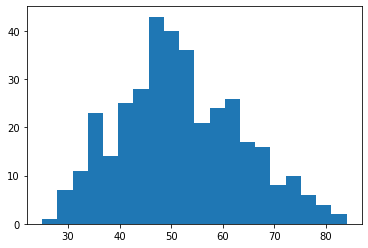

In [93]:
plt.hist(lengths, bins=20)

In [97]:
sub_beat_len = .46
# time of note is closest to 5th subbeat
time = 5.3 * sub_beat_len
round(time / sub_beat_len)

5

In [110]:
pm.instruments[0].notes[:10]

[Note(start=0.000000, end=0.105718, pitch=46, velocity=0.1968503937007874),
 Note(start=0.000000, end=0.205452, pitch=53, velocity=0.2992125984251969),
 Note(start=0.000000, end=0.226729, pitch=27, velocity=0.16535433070866143),
 Note(start=2.000000, end=0.589761, pitch=34, velocity=0.2283464566929134),
 Note(start=4.000000, end=0.724069, pitch=46, velocity=0.2047244094488189),
 Note(start=4.000000, end=0.787234, pitch=55, velocity=0.3543307086614173),
 Note(start=4.000000, end=0.928192, pitch=41, velocity=0.25196850393700787),
 Note(start=6.000000, end=1.268617, pitch=34, velocity=0.23622047244094488),
 Note(start=8.000000, end=1.414229, pitch=46, velocity=0.2992125984251969),
 Note(start=8.000000, end=1.489362, pitch=58, velocity=0.49606299212598426)]

In [74]:
def pm2nbq(pm, sub_beats):
    """like note bin, but quantized version
    
    Arguments:
    pm -- pretty midi object
    sub_beats -- number of sub beats per beat
    
    Returns:
    notes -- list of pm note objects, but with pitch in [0,87], velocity in [0,1], and start expressed as closest sub_beat number
    
    """
    
    sub_beat_len = pm.get_beats()[1] / sub_beats
    
    # don't want to edit the original pm object, so we make a copy of notes
    notes = copy.deepcopy(pm.instruments[0].notes)
    for note in notes:
        note.pitch = midi_utils.pitchM2pitchB(note.pitch)
        note.start = int(round(note.start / sub_beat_len))
        note.velocity = note.velocity / 127
    # rewrite note information for pm object. Need pitches and velocities in [0,1], and note starts expressed in nearest sub beat number
#     notes = [[midi_utils.pitchM2pitchB(note.pitch), round(note.start / sub_beat_len), note.velocity / 127] for note in pm.instruments[0].notes]
    
    return notes

def nbq2examples(notes, seq_length=60, sub_beats=2, example_bars_skip=4):
    """takes note_bin_q and returns examples of specified length
    
    Arguments:
    notes -- list of notes, note_bin_q style
    seq_length -- length of each example
    sub_beats -- number of sub beats per beat
    example_bars_skip -- examples start every example_skip bars
    
    Notes:
    four bars is around 50 notes, for the _8 dataset
    
    """
    
    # assuming that there are 4 beats to a bar!!!
    notes.sort(key = lambda note: note.start)
    # number of sub beats to skip forward by to get start of next example
    sub_beat_skip = example_bars_skip * 4 * sub_beats
#     n_examples = notes[-1].start // sub_beat_skip + 1
    
    # n prefix indicates it is by note - not by sub beat, as in HOV format
    TSn = [] # starts, in sub beats (of whole example)
    # these two together work as two indicator variables, together describing beat and sub beat
    TBn = [] # starting beat (of bar)
    TSBn = [] # starting sub beat (of beat)
    Pn = [] # pitches
    PSn = [] # pitch as continuous value in [0,1]
    PCn = [] # pitch class
    Vn = [] # velocities
    
    
    # variable for starting sub beat of current example
    example_sub_beat_start = 0
    while len(notes) >= seq_length:
        # get the values for the relevant notes
        # timing
        TSn.append([n.start - example_sub_beat_start for n in notes[:seq_length]])
        TBn.append([ts // sub_beats for ts in TSn[-1]])
        TSBn.append([ts % sub_beats for ts in TSn[-1]])
        
        # pitch
        Pn.append([n.pitch for n in notes[:seq_length]])
        PSn.append([p / 87 for p in Pn[-1]])
        PCn.append([p % 12 for p in Pn[-1]])
        
        # velocities
        Vn.append([n.velocity for n in notes[:seq_length]])
        
        example_sub_beat_start += sub_beat_skip
        
        # chop off example_skip beats from the start of the list of notes
        i = 0
        while notes[i].start < example_sub_beat_start:
            i += 1
        notes = notes[i:]
    
    return {'TSn': TSn, 'TBn': TBn, 'TSBn': TSBn, 'Pn': Pn, 'PSn': PSn, 'PCn': PCn, 'Vn': Vn}
        
        
        

pm = pretty_midi.PrettyMIDI('training_data/midi_train_8/mc_94_C.mid')
print(pm.instruments[0].notes[:5])
nbq = pm2nbq(pm, 2)
Sn = nbq2examples(nbq)
print(Sn.values())

        

# def note_bin_q2
    
    

[Note(start=0.012633, end=0.105718, pitch=67, velocity=25), Note(start=0.000000, end=0.205452, pitch=74, velocity=38), Note(start=0.004654, end=0.226729, pitch=48, velocity=21), Note(start=0.329787, end=0.589761, pitch=55, velocity=29), Note(start=0.632979, end=0.724069, pitch=67, velocity=26)]
dict_values([[[46, 53, 27, 34, 46, 55, 41, 34, 46, 58, 43, 34, 46, 53, 27, 34, 46, 55, 27, 34, 46, 58, 41, 34, 46, 53, 43, 34, 26, 34, 46, 53, 24, 31, 46, 55, 38, 31, 46, 58, 39, 31, 46, 53, 24, 31, 46, 55, 24, 31, 46, 58, 38, 31, 46, 53, 39, 31, 22, 31], [46, 53, 20, 27, 46, 55, 34, 27, 46, 58, 36, 27, 46, 53, 20, 27, 46, 55, 20, 27, 46, 58, 34, 27, 60, 46, 36, 27, 46, 58, 34, 27, 22, 46, 53, 29, 36, 29, 38, 29, 22, 29, 22, 29, 36, 29, 38, 29, 27, 46, 53, 34, 46, 55, 41, 34, 46, 58, 43, 34], [27, 46, 53, 34, 46, 55, 41, 34, 46, 58, 43, 34, 46, 53, 27, 34, 46, 55, 27, 34, 46, 58, 41, 34, 46, 53, 43, 34, 26, 34, 46, 53, 24, 31, 46, 55, 38, 31, 46, 58, 39, 31, 53, 46, 24, 31, 46, 55, 24, 31, 46, 5

In [69]:
17 % 16

1